# Notebook to explore netCDF files and change resolution, plus Python plotting
These files are downloaded from [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=download), using `cdsapi`. Get the data running the Python script `inout.py`:
```
python onehealth_db/inout.py
```

The downloaded files are stored in `data/in`. The `area` option uses values `90`, `90`, `-90`, `-90` for `North`, `East`, `South`, `West`, respectively.

Question: What is the coordinate reference system for the era5 dataset? NUTS3 either on EPSG 3035, 4326, 3857.

-> According to [ERA5-Land's documentation](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation):
> The data is referenced in the horizontal with respect to the WGS84 ellipse (which defines the major/minor axes) and in the vertical it is referenced to the EGM96 geoid over land but over ocean it is referenced to mean sea level, with the approximation that this is assumed to be coincident with the geoid. 

Then according to [this page](https://spatialreference.org/ref/epsg/9707/), it seems like the coordinate reference system for ERA5-Land is EPSG:9707

> ERA5-Land produces a total of 50 variables describing the
water and energy cycles over land, globally, hourly, and at a
spatial resolution of 9 km, matching the ECMWF triangular–
cubic–octahedral (TCo1279) operational grid (Malardel
et al., 2016).

In [1]:
from pathlib import Path
import xarray as xr
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

The following cells aim to explore the data structure

In [2]:
folder_path = Path("../data/in")

#### ERA5-Land from CDS

In [9]:
f_area_before_celsius = folder_path / "era5_data_2024_01_02_2t_tp_monthly_area.nc"
f_area_after_celsius = folder_path / "era5_data_2024_01_02_2t_tp_monthly_area_celsius.nc"

In [10]:
# load netCDF files
ds_area_before_celsius = xr.open_dataset(f_area_before_celsius)
ds_area_after_celsius = xr.open_dataset(f_area_after_celsius)

In [ ]:
ds_area_before_celsius

In [ ]:
ds_area_before_celsius.sel(latitude=20.0, longitude=10.0, method="nearest").to_dataframe().head(5)

In [ ]:
ds_area_before_celsius["tp"].attrs

In [11]:
ds_area_after_celsius

<xarray.Dataset> Size: 52MB
Dimensions:     (valid_time: 2, latitude: 1801, longitude: 1801)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 16B 2024-01-01 2024-02-01
  * latitude    (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
    expver      (valid_time) <U4 32B ...
  * longitude   (longitude) float64 14kB -90.0 -89.9 -89.8 ... 89.8 89.9 90.0
Data variables:
    t2m         (valid_time, latitude, longitude) float32 26MB ...
    tp          (valid_time, latitude, longitude) float32 26MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-08T08:34 GRIB to CDM+CF via cfgrib-0.9.1...

In [12]:
ds_area_after_celsius["tp"].attrs

{'GRIB_paramId': np.int64(228),
 'GRIB_dataType': 'fc',
 'GRIB_numberOfPoints': np.int64(3243601),
 'GRIB_typeOfLevel': 'surface',
 'GRIB_stepUnits': np.int64(1),
 'GRIB_gridType': 'regular_ll',
 'GRIB_uvRelativeToGrid': np.int64(0),
 'GRIB_NV': np.int64(0),
 'GRIB_Nx': np.int64(1801),
 'GRIB_Ny': np.int64(1801),
 'GRIB_cfName': 'unknown',
 'GRIB_cfVarName': 'tp',
 'GRIB_gridDefinitionDescription': 'Latitude/Longitude Grid',
 'GRIB_iDirectionIncrementInDegrees': np.float64(0.1),
 'GRIB_iScansNegatively': np.int64(0),
 'GRIB_jDirectionIncrementInDegrees': np.float64(0.1),
 'GRIB_jPointsAreConsecutive': np.int64(0),
 'GRIB_jScansPositively': np.int64(0),
 'GRIB_latitudeOfFirstGridPointInDegrees': np.float64(90.0),
 'GRIB_latitudeOfLastGridPointInDegrees': np.float64(-90.0),
 'GRIB_longitudeOfFirstGridPointInDegrees': np.float64(-90.0),
 'GRIB_longitudeOfLastGridPointInDegrees': np.float64(90.0),
 'GRIB_missingValue': np.float64(3.4028234663852886e+38),
 'GRIB_name': 'Total precipitation'

In [ ]:
ds_area_after_celsius.sel(latitude=20.0, longitude=10.0, method="nearest").to_dataframe().head(5)

In [ ]:
lat = 20.0
lon = 10.0
ds_area_after_celsius["t2m"].sel(latitude=lat, longitude=lon, method="nearest").plot(color="blue", marker="o")
plt.title("2m temperature in 2024 at lat-{}, lon-{}".format(lat, lon))
plt.show()


In [ ]:
# plot the data for the first month
ds_area_after_celsius.t2m[0].plot(size = 7)

In [ ]:
ds_area_after_celsius.tp[0].plot(size = 7)

In [ ]:
# convert to dataframe
df = ds_area_after_celsius.to_dataframe().reset_index()
df

#### Population data from ISIMIP

In [3]:
f_popu_data = folder_path / "population_histsoc_30arcmin_annual_1901_2021.nc"
ds_popu_data = xr.open_dataset(f_popu_data)

In [4]:
ds_popu_data

<xarray.Dataset> Size: 376MB
Dimensions:           (lat: 360, lon: 720, time: 121)
Coordinates:
  * lat               (lat) float64 3kB 89.75 89.25 88.75 ... -89.25 -89.75
  * lon               (lon) float64 6kB -179.8 -179.2 -178.8 ... 179.2 179.8
  * time              (time) datetime64[ns] 968B 1901-01-01T12:00:00 ... 2021...
Data variables:
    rural-population  (time, lat, lon) float32 125MB ...
    total-population  (time, lat, lon) float32 125MB ...
    urban-population  (time, lat, lon) float32 125MB ...
Attributes:
    summary:     HYDE v3.3 population data linearly interpolated in time for ...
    references:  Klein Goldewijk et al. (2022), in preparation
    title:       ISIMIP3a population data
    contact:     "ISIMIP cross-sectoral science team" <info@isimip.org>

In [5]:
ds_popu_data["total-population"].attrs

{'units': '1', 'standard_name': 'total population'}

In [6]:
test_popu_data = ds_popu_data.sel(lat=8.67, lon=49.39, method="nearest").to_dataframe()
test_popu_data.head(5)

,lat,lon,rural-population,total-population,urban-population
time,,,,,
1901-01-01 12:00:00,8.75,49.25,3132.187500,3132.187500,0.0
1902-01-01 12:00:00,8.75,49.25,3148.900391,3148.900391,0.0
1903-01-01 12:00:00,8.75,49.25,3165.613281,3165.613281,0.0
1904-01-01 12:00:00,8.75,49.25,3182.326416,3182.326416,0.0
1905-01-01 12:00:00,8.75,49.25,3199.085205,3199.085205,0.0


<Axes: xlabel='time'>

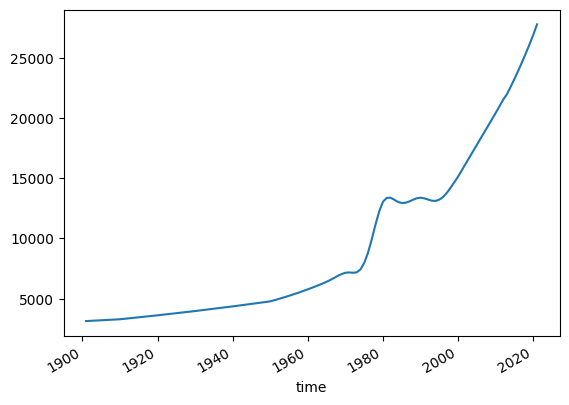

In [7]:
test_popu_data["total-population"].plot()

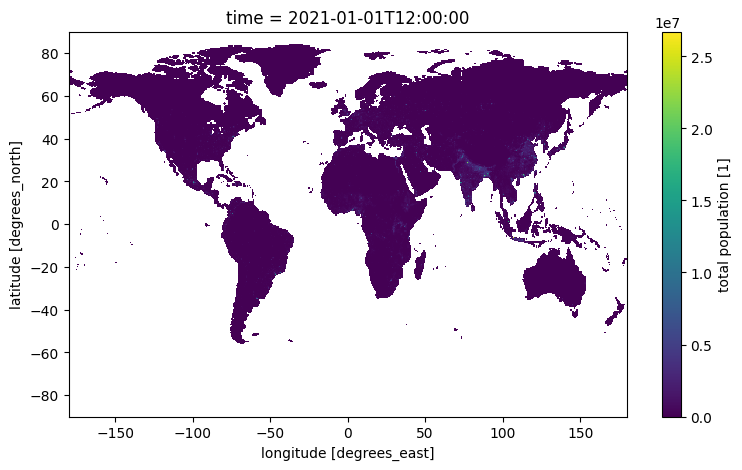

In [8]:
ds_popu_data["total-population"][-1].plot(figsize=(9, 5))

In [56]:
# save the population data of 2021 to a csv file
popu_data = ds_popu_data[["time", "lat", "lon", "total-population"]].sel(time="2021-01-01").to_dataframe().reset_index()
# change column names to make it consistent with the other data
popu_data.rename(columns={"time": "valid_time", "lat": "latitude", "lon": "longitude", "total-population": "popu"}, inplace=True)
popu_data

,valid_time,latitude,longitude,popu
0,2021-01-01 12:00:00,89.75,-179.75,NaN
1,2021-01-01 12:00:00,89.75,-179.25,NaN
2,2021-01-01 12:00:00,89.75,-178.75,NaN
3,2021-01-01 12:00:00,89.75,-178.25,NaN
4,2021-01-01 12:00:00,89.75,-177.75,NaN
...,...,...,...,...
259195,2021-01-01 12:00:00,-89.75,177.75,NaN
259196,2021-01-01 12:00:00,-89.75,178.25,NaN
259197,2021-01-01 12:00:00,-89.75,178.75,NaN
259198,2021-01-01 12:00:00,-89.75,179.25,NaN


In [57]:
popu_data_clean = popu_data.dropna()
popu_data_clean

,valid_time,latitude,longitude,popu
8924,2021-01-01 12:00:00,83.75,-37.75,0.000000
8926,2021-01-01 12:00:00,83.75,-36.75,0.000000
8927,2021-01-01 12:00:00,83.75,-36.25,0.000000
8928,2021-01-01 12:00:00,83.75,-35.75,0.000000
8929,2021-01-01 12:00:00,83.75,-35.25,0.000000
...,...,...,...,...
209741,2021-01-01 12:00:00,-55.75,-69.25,1.240095
209742,2021-01-01 12:00:00,-55.75,-68.75,0.006180
209743,2021-01-01 12:00:00,-55.75,-68.25,61.542282
209744,2021-01-01 12:00:00,-55.75,-67.75,2.449560


In [58]:
# save population data to a csv file
popu_data.to_csv("../data/out/isimip_population_with_NAN_2021.csv", index=False)
popu_data_clean.to_csv("../data/out/isimip_population_2021.csv", index=False)

In [7]:
# a file from provided materials
f_popu_dens_2024 = folder_path / "pop_dens_2024_global_0.5.nc"
ds_popu_dens_2024 = xr.open_dataset(f_popu_dens_2024, decode_times=False) # add decode_times=False to avoid error
f_dens_example = folder_path / "dens_example.nc"
ds_dens_example = xr.open_dataset(f_dens_example)

In [ ]:
ds_popu_dens_2024

In [ ]:
ds_popu_dens_2024["dens"].attrs

In [8]:
ds_popu_dens_2024.sel(lat=8.67, lon=49.39, method="nearest").to_dataframe().head(5)

,lon,lat,crs,dens
time,,,,
0.0,49.25,8.75,b'',9.074893


In [ ]:
ds_dens_example

In [ ]:
ds_dens_example.to_dataframe().head(5)

## Downsampling of the data and setting the correct accuracy for the dataframe

In [24]:
# aggregate the data to a 1/2 degree grid, about 50km x 50 km
# already here the numerical accuracy of the grid values is problematic, so we need to round
output_grid_resolution = 1/2
input_grid_resolution = np.round((ds_area_after_celsius.longitude[1]-ds_area_after_celsius.longitude[0]).item(),2)
print("Initial grid resolution is {}, downsampling to {} degree resolution".format(input_grid_resolution, output_grid_resolution))
weight = int(np.ceil(output_grid_resolution / input_grid_resolution))
print("Weight is {}".format(weight))

Initial grid resolution is 0.1, downsampling to 0.5 degree resolution
Weight is 5


In [25]:
ds_area_after_celsius_resampled = ds_area_after_celsius.coarsen(longitude=weight, boundary="pad").mean().coarsen(latitude=weight, boundary="pad").mean()
ds_area_after_celsius_resampled

<xarray.Dataset> Size: 2MB
Dimensions:     (valid_time: 2, latitude: 361, longitude: 361)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 16B 2024-01-01 2024-02-01
  * latitude    (latitude) float64 3kB 89.8 89.3 88.8 88.3 ... -89.2 -89.7 -90.0
    expver      (valid_time) <U4 32B '0001' '0001'
  * longitude   (longitude) float64 3kB -89.8 -89.3 -88.8 ... 89.2 89.7 90.0
Data variables:
    t2m         (valid_time, latitude, longitude) float32 1MB nan nan ... -38.3
    tp          (valid_time, latitude, longitude) float32 1MB nan ... 8.772e-05
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-08T08:34 GRIB to CDM+CF via cfgrib-0.9.1...

In [26]:
downsampled_grid = float(ds_area_after_celsius_resampled.longitude[1] - ds_area_after_celsius_resampled.longitude[0])
print("Downsampled grid resolution is {}".format(downsampled_grid))

Downsampled grid resolution is 0.4999999999999858


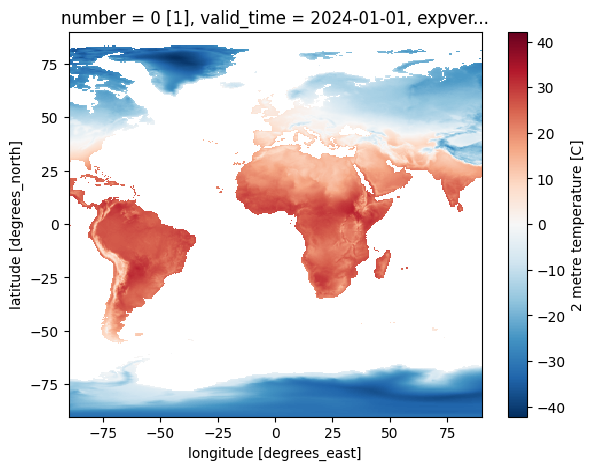

In [27]:
# plot the data for the first month
ds_area_after_celsius_resampled.t2m[0].plot(size = 5)

In [28]:
# convert to dataframe
df = ds_area_after_celsius_resampled.to_dataframe().reset_index()
df

,valid_time,latitude,longitude,t2m,tp,number,expver
0,2024-01-01,89.8,-89.8,NaN,NaN,0,0001
1,2024-01-01,89.8,-89.3,NaN,NaN,0,0001
2,2024-01-01,89.8,-88.8,NaN,NaN,0,0001
3,2024-01-01,89.8,-88.3,NaN,NaN,0,0001
4,2024-01-01,89.8,-87.8,NaN,NaN,0,0001
...,...,...,...,...,...,...,...
260637,2024-02-01,-90.0,88.2,-38.30394,0.000088,0,0001
260638,2024-02-01,-90.0,88.7,-38.30394,0.000088,0,0001
260639,2024-02-01,-90.0,89.2,-38.30394,0.000088,0,0001
260640,2024-02-01,-90.0,89.7,-38.30394,0.000088,0,0001


In [29]:
# change the unit of tp to mm
df["tp"] = df["tp"] * 1000

In [30]:
out_data = df[["valid_time", "latitude", "longitude", "t2m", "tp"]]
out_data = out_data[out_data['valid_time'] == '2024-02-01']

In [31]:
# drop all nan values and filter by time
out_data_clean = out_data.dropna()
out_data_clean

,valid_time,latitude,longitude,t2m,tp
135045,2024-02-01,83.3,-74.3,-26.757065,0.445526
135048,2024-02-01,83.3,-72.8,-28.395737,0.453756
135052,2024-02-01,83.3,-70.8,-28.923080,0.385099
135053,2024-02-01,83.3,-70.3,-28.999252,0.346914
135054,2024-02-01,83.3,-69.8,-28.999252,0.346914
...,...,...,...,...,...
260637,2024-02-01,-90.0,88.2,-38.303940,0.087716
260638,2024-02-01,-90.0,88.7,-38.303940,0.087716
260639,2024-02-01,-90.0,89.2,-38.303940,0.087716
260640,2024-02-01,-90.0,89.7,-38.303940,0.087716


In [ ]:
out_data.to_csv("../data/out/era5_data_2024_01_02_2t_tp_monthly_area_celsius_with_NaN_february_resampled_05degree.csv", index=False)
popu_data_clean.to_csv("../data/out/era5_data_2024_01_02_2t_tp_monthly_area_celsius_february_resampled_05degree.csv", index=False)

## Export to geopandas for other plotting options and geospatial analysis

In [47]:
# xarray data to geopandas
# Create geometry column using latitude and longitude
geometry = [Point(xy) for xy in zip(out_data_clean['longitude'], out_data_clean['latitude'])]

for epsg in [4326, 9707]:
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(out_data_clean, geometry=geometry)

    # Set the coordinate reference system (CRS) if known (e.g., WGS84)
    gdf.set_crs(epsg=epsg, inplace=True)

    # Save to a GeoJSON file
    gdf.to_file(f"../data/out/era5_data_2024_01_02_2t_tp_monthly_area_celsius_February_resampled_05degree_{epsg}.geojson", driver="GeoJSON")

In [62]:
# compare two files to see if the epsg makes a difference
gdf_9707 = gpd.read_file("../data/out/era5_data_2024_01_02_2t_tp_monthly_area_celsius_February_resampled_05degree_9707.geojson")
gdf_4326 = gpd.read_file("../data/out/era5_data_2024_01_02_2t_tp_monthly_area_celsius_February_resampled_05degree_4326.geojson")
diff = gdf_9707.compare(gdf_4326)
if diff.empty:
    print("The two files are identical.")
else:
    print("The two files are different.")
    print(diff)

The two files are identical.


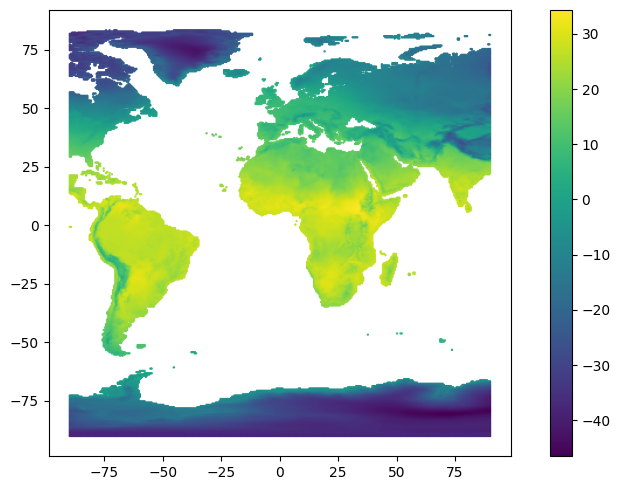

In [63]:
fig, ax = plt.subplots(figsize=(8,5))
gdf_4326.plot(ax=ax, column="t2m", legend=True, markersize=0.5)
fig.tight_layout()
fig.savefig("february_t2m.pdf")

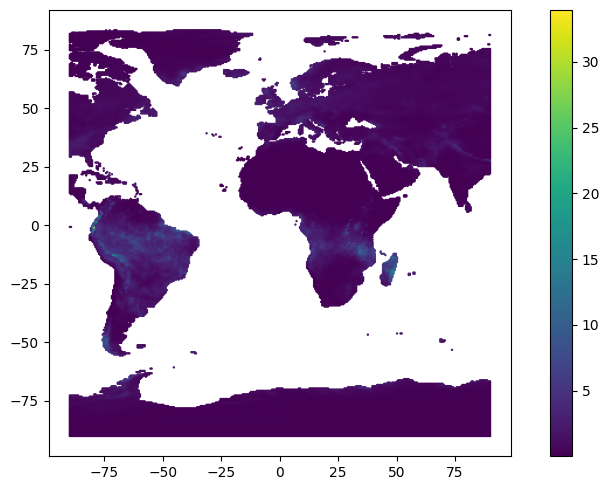

In [64]:
fig, ax = plt.subplots(figsize=(8,5))
gdf_4326.plot(ax=ax, column="tp", legend=True, markersize=0.5)
fig.tight_layout()
fig.savefig("february_tp.pdf")

### Export to geopandas for population data

In [59]:
# xarray data to geopandas
# Create geometry column using latitude and longitude
geometry = [Point(xy) for xy in zip(popu_data_clean['longitude'], popu_data_clean['latitude'])]

for epsg in [4326, 9707]:
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(popu_data_clean, geometry=geometry)

    # Set the coordinate reference system (CRS) if known (e.g., WGS84)
    gdf.set_crs(epsg=epsg, inplace=True)

    # Save to a GeoJSON file
    gdf.to_file(f"../data/out/isimip_population_2021_05degree_{epsg}.geojson", driver="GeoJSON")

In [65]:
# compare two files to see if the epsg makes a difference
popu_gdf_9707 = gpd.read_file("../data/out/isimip_population_2021_05degree_9707.geojson")
popu_gdf_4326 = gpd.read_file("../data/out/isimip_population_2021_05degree_4326.geojson")
diff = popu_gdf_9707.compare(popu_gdf_4326)
if diff.empty:
    print("The two files are identical.")
else:
    print("The two files are different.")
    print(diff)

The two files are identical.


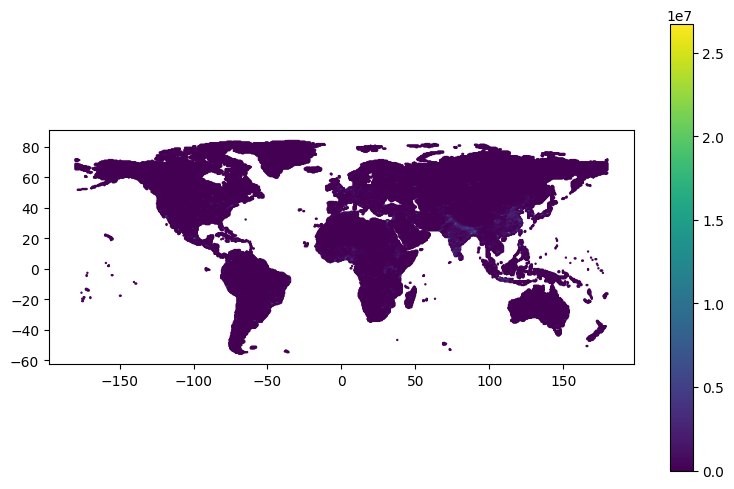

In [66]:
fig, ax = plt.subplots(figsize=(8,5))
popu_gdf_4326.plot(ax=ax, column="popu", legend=True, markersize=0.5)
fig.tight_layout()
fig.savefig("isimip_population_2021.pdf")

## Resample to NUTS3 level
Use the same `crs` for geopandas export and the shapefile export from Eurostat.

In [67]:
# read the shapefile
shapefile_path = Path("../data/in/NUTS_RG_20M_2024_4326.shp")
nuts3 = gpd.GeoDataFrame.from_file(shapefile_path)
nuts3

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry
0,AL011,3,AL,Dibër,Dibër,NaN,NaN,NaN,"POLYGON ((20.2208 41.86937, 20.56287 41.84614,..."
1,AL012,3,AL,Durrës,Durrës,NaN,NaN,NaN,"POLYGON ((19.55733 41.57767, 19.83218 41.56823..."
2,AL013,3,AL,Kukës,Kukës,NaN,NaN,NaN,"POLYGON ((20.59429 41.87733, 20.56287 41.84614..."
3,AL014,3,AL,Lezhë,Lezhë,NaN,NaN,NaN,"POLYGON ((19.52007 41.84031, 19.48726 41.9043,..."
4,AL015,3,AL,Shkodër,Shkodër,NaN,NaN,NaN,"POLYGON ((19.37253 41.84415, 19.38072 42.00458..."
...,...,...,...,...,...,...,...,...,...
1793,RO224,3,RO,Galaţi,Galaţi,NaN,2.0,NaN,"POLYGON ((28.03052 45.40433, 27.55852 45.48838..."
1794,RO225,3,RO,Tulcea,Tulcea,NaN,3.0,1.0,"POLYGON ((28.99409 44.67963, 28.50469 44.65529..."
1795,RO226,3,RO,Vrancea,Vrancea,1.0,3.0,NaN,"POLYGON ((27.43473 45.3947, 27.11334 45.43295,..."
1796,RO311,3,RO,Argeş,Argeş,NaN,2.0,NaN,"POLYGON ((24.43812 44.84538, 24.50187 45.02039..."


In [68]:
gdf_4326

,valid_time,latitude,longitude,t2m,tp,geometry
0,2024-02-01,83.3,-74.3,-26.757065,0.445526,POINT (-74.3 83.3)
1,2024-02-01,83.3,-72.8,-28.395737,0.453756,POINT (-72.8 83.3)
2,2024-02-01,83.3,-70.8,-28.923080,0.385099,POINT (-70.8 83.3)
3,2024-02-01,83.3,-70.3,-28.999252,0.346914,POINT (-70.3 83.3)
4,2024-02-01,83.3,-69.8,-28.999252,0.346914,POINT (-69.8 83.3)
...,...,...,...,...,...,...
55189,2024-02-01,-90.0,88.2,-38.303940,0.087716,POINT (88.2 -90)
55190,2024-02-01,-90.0,88.7,-38.303940,0.087716,POINT (88.7 -90)
55191,2024-02-01,-90.0,89.2,-38.303940,0.087716,POINT (89.2 -90)
55192,2024-02-01,-90.0,89.7,-38.303940,0.087716,POINT (89.7 -90)


In [69]:
popu_gdf_4326

,valid_time,latitude,longitude,popu,geometry
0,2021-01-01 12:00:00,83.75,-37.75,0.000000,POINT (-37.75 83.75)
1,2021-01-01 12:00:00,83.75,-36.75,0.000000,POINT (-36.75 83.75)
2,2021-01-01 12:00:00,83.75,-36.25,0.000000,POINT (-36.25 83.75)
3,2021-01-01 12:00:00,83.75,-35.75,0.000000,POINT (-35.75 83.75)
4,2021-01-01 12:00:00,83.75,-35.25,0.000000,POINT (-35.25 83.75)
...,...,...,...,...,...
67990,2021-01-01 12:00:00,-55.75,-69.25,1.240095,POINT (-69.25 -55.75)
67991,2021-01-01 12:00:00,-55.75,-68.75,0.006180,POINT (-68.75 -55.75)
67992,2021-01-01 12:00:00,-55.75,-68.25,61.542282,POINT (-68.25 -55.75)
67993,2021-01-01 12:00:00,-55.75,-67.75,2.449560,POINT (-67.75 -55.75)


### Merge t2m and tp data with NUTS3

In [81]:
# Spatial join for points in polygons
era5_merge = gpd.tools.sjoin(gdf_4326, nuts3, how='left')

# drop non-merged obs
era5_matched = era5_merge[~era5_merge['NUTS_NAME'].isna()]
# show result
era5_matched.head()

,valid_time,latitude,longitude,t2m,tp,geometry,index_right,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE
960,2024-02-01,80.3,19.7,-10.310566,0.718584,POINT (19.7 80.3),377.0,NO,0.0,NO,Norge,Norge,NaN,NaN,NaN
960,2024-02-01,80.3,19.7,-10.310566,0.718584,POINT (19.7 80.3),316.0,NO0,1.0,NO,Norge,Norge,NaN,NaN,NaN
960,2024-02-01,80.3,19.7,-10.310566,0.718584,POINT (19.7 80.3),164.0,NO0B,2.0,NO,Svalbard og Jan Mayen,Svalbard og Jan Mayen,NaN,NaN,NaN
960,2024-02-01,80.3,19.7,-10.310566,0.718584,POINT (19.7 80.3),1430.0,NO0B2,3.0,NO,Svalbard,Svalbard,NaN,NaN,NaN
961,2024-02-01,80.3,20.2,-11.459393,0.711891,POINT (20.2 80.3),377.0,NO,0.0,NO,Norge,Norge,NaN,NaN,NaN


In [82]:
ear5_aggregated_by_NUTS3 = era5_matched.groupby("NUTS_ID")[["t2m", "tp"]].mean().reset_index()
ear5_aggregated_by_NUTS3

,NUTS_ID,t2m,tp
0,AL,6.843470,1.065287
1,AL0,6.843470,1.065287
2,AL01,5.861004,1.262017
3,AL011,5.127872,0.772801
4,AL013,5.128262,0.976278
...,...,...,...
1342,XK00,5.140958,0.303576
1343,XK001,5.339747,0.220865
1344,XK002,5.072950,0.314184
1345,XK004,5.124981,0.366353


In [84]:
era5_nuts = nuts3.merge(ear5_aggregated_by_NUTS3, on="NUTS_ID")
era5_nuts = era5_nuts.filter(["NUTS_ID",'geometry', 't2m', 'tp'])
era5_nuts

,NUTS_ID,geometry,t2m,tp
0,AL011,"POLYGON ((20.2208 41.86937, 20.56287 41.84614,...",5.127872,0.772801
1,AL013,"POLYGON ((20.59429 41.87733, 20.56287 41.84614...",5.128262,0.976278
2,AL014,"POLYGON ((19.52007 41.84031, 19.48726 41.9043,...",8.431024,1.126432
3,AL015,"POLYGON ((19.37253 41.84415, 19.38072 42.00458...",4.756856,2.172558
4,AL021,"POLYGON ((20.23617 41.34849, 20.42165 41.38186...",5.884982,0.685372
...,...,...,...,...
1342,RO224,"POLYGON ((28.03052 45.40433, 27.55852 45.48838...",7.292638,0.069627
1343,RO225,"POLYGON ((28.99409 44.67963, 28.50469 44.65529...",7.396559,0.097134
1344,RO226,"POLYGON ((27.43473 45.3947, 27.11334 45.43295,...",5.834786,0.227232
1345,RO311,"POLYGON ((24.43812 44.84538, 24.50187 45.02039...",3.951127,0.390008


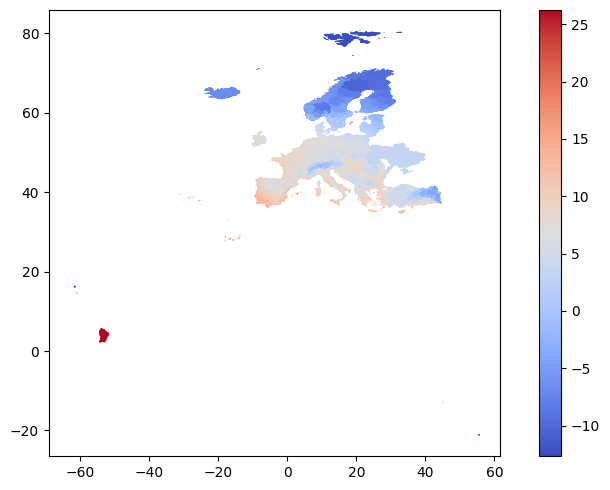

In [85]:
# plot the NUTS3 regions with the t2m
fig, ax = plt.subplots(figsize=(8, 5))
era5_nuts.plot(ax=ax, column='t2m', legend=True, markersize=0.5, cmap='coolwarm')
plt.tight_layout()
fig.savefig('era5_t2m_nuts3_export.pdf')

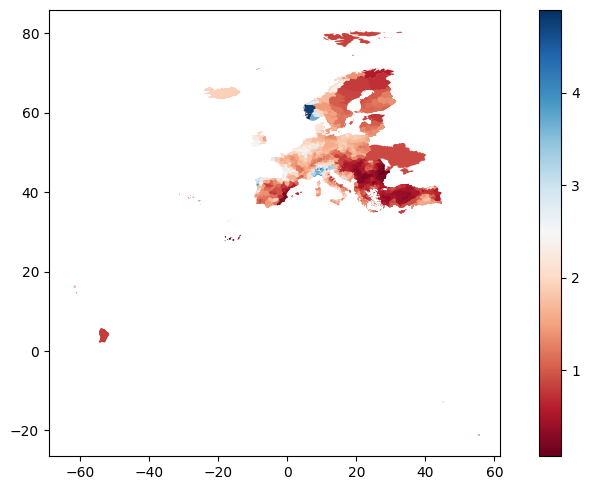

In [94]:
# plot the NUTS3 regions with the t2m
fig, ax = plt.subplots(figsize=(8, 5))
era5_nuts.plot(ax=ax, column='tp', legend=True, markersize=0.5, cmap='RdBu')
plt.tight_layout()
fig.savefig('era5_tp_nuts3_export.pdf')

In [95]:
# export the NUTS3 regions with the t2m as csv
era5_nuts.to_csv("../data/out/era5_data_2024_01_02_monthly_area_celsius_february_resampled_05degree_NUTS3.csv", index=False)

### Merge population data with NUTS3

In [96]:
# Spatial join for points in polygons
popu_merge = gpd.tools.sjoin(popu_gdf_4326, nuts3, how='left')

# drop non-merged obs
popu_matched = popu_merge[~popu_merge['NUTS_NAME'].isna()]
# show result
popu_matched.head()

,valid_time,latitude,longitude,popu,geometry,index_right,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE
1066,2021-01-01 12:00:00,80.25,19.75,0.0,POINT (19.75 80.25),377.0,NO,0.0,NO,Norge,Norge,NaN,NaN,NaN
1066,2021-01-01 12:00:00,80.25,19.75,0.0,POINT (19.75 80.25),316.0,NO0,1.0,NO,Norge,Norge,NaN,NaN,NaN
1066,2021-01-01 12:00:00,80.25,19.75,0.0,POINT (19.75 80.25),164.0,NO0B,2.0,NO,Svalbard og Jan Mayen,Svalbard og Jan Mayen,NaN,NaN,NaN
1066,2021-01-01 12:00:00,80.25,19.75,0.0,POINT (19.75 80.25),1430.0,NO0B2,3.0,NO,Svalbard,Svalbard,NaN,NaN,NaN
1067,2021-01-01 12:00:00,80.25,20.25,0.0,POINT (20.25 80.25),377.0,NO,0.0,NO,Norge,Norge,NaN,NaN,NaN


In [98]:
popu_aggregated_by_NUTS3 = popu_matched.groupby("NUTS_ID")["popu"].mean().reset_index()
popu_aggregated_by_NUTS3

,NUTS_ID,popu
0,AL,216924.73725
1,AL0,216924.73725
2,AL01,178196.06000
3,AL011,140705.02000
4,AL013,249692.19000
...,...,...
1345,XK001,404868.84000
1346,XK002,370122.69000
1347,XK003,242122.86000
1348,XK004,448664.25000


In [99]:
popu_nuts = nuts3.merge(popu_aggregated_by_NUTS3, on="NUTS_ID")
popu_nuts = popu_nuts.filter(["NUTS_ID",'geometry', 'popu'])
popu_nuts

,NUTS_ID,geometry,popu
0,AL011,"POLYGON ((20.2208 41.86937, 20.56287 41.84614,...",140705.020000
1,AL013,"POLYGON ((20.59429 41.87733, 20.56287 41.84614...",249692.190000
2,AL014,"POLYGON ((19.52007 41.84031, 19.48726 41.9043,...",175692.890000
3,AL015,"POLYGON ((19.37253 41.84415, 19.38072 42.00458...",146694.140000
4,AL021,"POLYGON ((20.23617 41.34849, 20.42165 41.38186...",181200.813000
...,...,...,...
1345,RO224,"POLYGON ((28.03052 45.40433, 27.55852 45.48838...",119971.320000
1346,RO225,"POLYGON ((28.99409 44.67963, 28.50469 44.65529...",121291.959250
1347,RO226,"POLYGON ((27.43473 45.3947, 27.11334 45.43295,...",189176.572000
1348,RO311,"POLYGON ((24.43812 44.84538, 24.50187 45.02039...",188100.176667


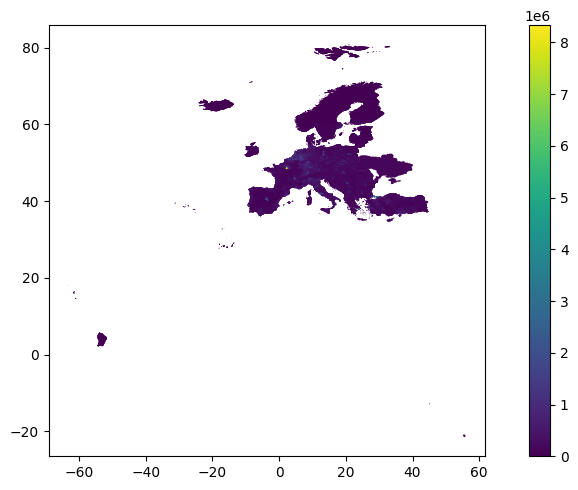

In [100]:
# plot the NUTS3 regions with the t2m
fig, ax = plt.subplots(figsize=(9, 5))
popu_nuts.plot(ax=ax, column='popu', legend=True, markersize=0.5)
plt.tight_layout()
fig.savefig('popu_nuts3_export.pdf')

In [101]:
# export the NUTS3 regions with the t2m as csv
popu_nuts.to_csv("../data/out/isimip_population_2021_05degree_4326_05degree_NUTS3.csv", index=False)